#             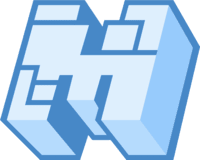
---
**Minecolab**
---
Original: [En - Mine Colab](https://github.com/thecoder-001/MineColab)

---

In [ ]:
# @title **[ IMPORTANT ] : Set up** {display-mode: "form"}

import subprocess
import re
import glob
import requests
import time
from json import load, dump
import os
try: from jproperties import Properties
except:
  !pip install -q jproperties
  from jproperties import Properties
try: from rich import print
except:
  !pip install -q rich
  from rich import print
if os.path.exists('/content/drive') == False:
  from google.colab import drive, runtime
  drive.mount('/content/drive')
else: from google.colab import runtime
try: from pyngrok import conf, ngrok
except:
  !pip -q install pyngrok
  from pyngrok import conf, ngrok

#------------------------------------------------------------------------------------------------------------------------------------#

!command -v filebrowser &>/dev/null || curl -fsSL https://raw.githubusercontent.com/filebrowser/get/master/get.sh | bash &>/dev/null
!sudo apt update &>/dev/null &&echo 'apt cache successfully updated' || echo "apt cache update failed, you might receive stale packages"
!sudo apt upgrade &>/dev/null &&echo 'apt cache successfully upgraded' || echo "apt cache upgrade failed, you might receive stale packages"

#------------------------------------------------------------------------------------------------------------------------------------#
def SETUP():
  if os.path.exists('/content/drive/MyDrive/minecraft') == False:
    subprocess.run(['mkdir', '-p', '/content/drive/MyDrive/minecraft'])

  if os.path.exists(SERVERCONFIG) == False:
    serverconfig = {"server_list": [], "server_in_use": ""}
    with open(SERVERCONFIG, 'w') as f:
      dump(serverconfig, f)
def LOG(text):
  if '\n' in str(text):
    print("\n[bold green][ LOG ][/bold green] " + str(text).replace('\n', ''))
  else:
    print("[bold green][ LOG ][/bold green] " + str(text))
def EROR(text):
  print("[bold red][ EROR ][/bold red] " + str(text))
def EXIT():
  runtime.unassign()

def COLABCONFIG(server_name: str):
  return f"/content/drive/My Drive/minecraft/{server_name}/colabconfig.txt"
def COLABCONFIG_LOAD(server_name):
  if os.path.exists(COLABCONFIG(server_name)):
    return load(open(COLABCONFIG(server_name)))
  else:
    colabconfig = {"server_type": "generic"} # using default, if config doesn't exist.
    dump(colabconfig, open("colabconfig.json",'w'))
    LOG('Please checking whether you deleted your colabconfig file or not.')
    EXIT()
def COLABCONFIG_CHECK(server_name, colabconfig):
  colabconfig['check'] = True
  dump(colabconfig, open(COLABCONFIG(server_name), 'w'))

SERVERCONFIG = '/content/drive/My Drive/minecraft/server_list.txt'
def SERVER_IN_USE():
  serverconfig = load(open(SERVERCONFIG))
  return serverconfig['server_in_use']

def DOWNLOAD_FILE(url, path, file_name):
  r = requests.get(url)
  if r.status_code == 200:
    if file_name != None: LOG('\nDownloading ' + file_name)
    with open(path, 'wb') as f:
          f.write(r.content)
  else:
    LOG('Error '+ str(r.status_code) + '! Most likely you entered an unsupported version. Try running the code again if you think that shouldn\'t have happened.')

def EULA(server_name: str):
  LOG('\nAccepting Eula.')
  with open(f'/content/drive/My Drive/minecraft/{server_name}/eula.txt', 'w') as f:
    f.seek(0)
    f.write("eula=true")
#--------------------------------------------------------- INSTALL JAVA --------------------------------------------------------------#
def JAVA_VER():
  java_ver = !java -version 2>&1 | awk -F[\"\.] -v OFS=. 'NR==1{print $2}'
  return java_ver
def INSTALL_JAVA(version: str):
  # !wget -qO - https://adoptopenjdk.jfrog.io/adoptopenjdk/api/gpg/key/public | sudo apt-key add -
  # !sudo add-apt-repository --yes https://adoptopenjdk.jfrog.io/adoptopenjdk/deb/ &>/dev/null || echo "Failed to add repo. Still can be ignored if openjdk gets installed."
  if version > "1.17":
    !sudo apt-get install openjdk-17-jre-headless &>/dev/null &&echo "Openjdk17 successfully installed" || echo "Failed to install OpenJdk17."
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
    !update-alternatives --set java /usr/lib/jvm/java-17-openjdk-amd64/bin/java
  else:
    !sudo apt-get install openjdk-8-jre-headless &>/dev/null &&echo "Openjdk8 successfully installed" || echo "Failed to install OpenJdk8."
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    !update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
def JAVA_CHECK():
  if JAVA_VER()[0] == "1" : LOG("Openjdk8 is working correctly, you are good to go.")
  elif JAVA_VER()[0] == '17': LOG("Openjdk17 is working correctly, you are good to go.")
  else:
    LOG("Openjdk doesn't seem to be installed or isn't working, falling back to java" + str(java_ver[0]))
    LOG('You might experience reduced performance. Minecraft 1.17 and above might fail to launch.')
#-------------------------------------------------------- Java arguments ------------------------------------------------------------------#
def ARGS(type_):
  AIKAR_FLAGS = '-XX:+UseG1GC -XX:+ParallelRefProcEnabled -XX:MaxGCPauseMillis=200 -XX:+UnlockExperimentalVMOptions -XX:+DisableExplicitGC -XX:+AlwaysPreTouch -XX:G1NewSizePercent=30 -XX:G1MaxNewSizePercent=40 -XX:G1HeapRegionSize=8M -XX:G1ReservePercent=20 -XX:G1HeapWastePercent=5 -XX:G1MixedGCCountTarget=4 -XX:InitiatingHeapOccupancyPercent=15 -XX:G1MixedGCLiveThresholdPercent=90 -XX:G1RSetUpdatingPauseTimePercent=5 -XX:SurvivorRatio=32 -XX:+PerfDisableSharedMem -XX:MaxTenuringThreshold=1 -Dusing.aikars.flags=https://mcflags.emc.gs -Daikars.new.flags=true'
  GC_LOG = '-d64 -Xloggc:gc.log -verbose:gc -XX:+PrintGCDetails -XX:+PrintGCDateStamps -XX:+PrintGCTimeStamps -XX:+UseGCLogFileRotation -XX:NumberOfGCLogFiles=5 -XX:GCLogFileSize=1M'
  GC_LOG2 = '-d64 -Xlog:gc*:logs/gc.log:time,uptime:filecount=5,filesize=1M'
  FORGE_FLAGS = '-XX:+UseG1GC -Dsun.rmi.dgc.server.gcInterval=2147483646 -XX:+UnlockExperimentalVMOptions -XX:G1NewSizePercent=20 -XX:G1ReservePercent=20 -XX:MaxGCPauseMillis=50 -XX:G1HeapRegionSize=32M'
  args = "-Xms10G -Xmx10G"
  if type_ == "paper" or type_ == 'purpur':
    args += AIKAR_FLAGS # Improving paper cilent. For more detailed: https://docs.papermc.io/paper/aikars-flags
  elif type_ == 'forge':
    args += FORGE_FLAGS
  if JAVA_VER()[0] == "1" : args += GC_LOG
  elif JAVA_VER()[0] >= '11': args += GC_LOG2
  return args
#------------------------------------------------------- INSTALL SERVER.JAR -------------------------------------------------------------#
SERVERSJAR_URL = {
    'vanilla'   : '/vanilla/vanilla',    'snapshot'  : '/vanilla/snapshot',
    'paper'     : "/servers/paper/",     "purpur"    : "/servers/purpur/",
    "fabric"    : "/modded/fabric",      "forge"     : "/modded/forge",
    "bungeecord": "/proxies/bungeecord", "waterfall" : "/proxies/waterfall/", "velocity"  : "/proxies/velocity"
    }
def JAR_LIST_RUN(colabconfig: dict):
  return {'vanilla':'server.jar','snapshot': 'server.jar',
          'purpur' : 'server.jar', 'paper': 'server.jar',
          'fabric': 'fabric-launcher.jar', 'forge': 'minecraft_server.' + colabconfig['server_version'] + '.jar',
          'bungeecord' : 'server.jar', 'waterfall' : 'server.jar', 'velocity' : 'server.jar', 'generic': 'server.jar'}
JAR_LIST_INSTALL = {'vanilla':'server.jar', 'snapshot': 'server.jar',
                      'purpur' : 'server.jar', 'paper': 'server.jar',
              'fabric': 'fabric-launcher.jar', 'forge': 'forge-installer.jar',
              'bungeecord' : 'server.jar', 'waterfall' : 'server.jar', 'velocity' : 'server.jar'}
def SERVERSJAR(all = False, jar = False, server_type= '', version = None):
  if all:
    return 'https://serverjars.com/api/fetchAll' + SERVERSJAR_URL[server_type]
  elif jar == True and version != None:
    return 'https://serverjars.com/api/fetchJar' + SERVERSJAR_URL[server_type] + f'/{version}'
  else:
    EROR('Type error: Wrong given arguments')
def GET_VERSION(server_type):
  LOG('\n Aivailable version:')
  a = requests.get(SERVERSJAR(all = True, server_type= server_type)).json()
  server_version = [hit['version'] for hit in a['response']]
  LOG(server_version)
  version = input('Server version: ')
  return version
def GET_SERVERJAR(server_name, type_, version, jarname = 'server.jar'):
  DOWNLOAD_FILE(url= SERVERSJAR(jar = True, server_type = type_, version= version),
                path = f"/content/drive/My Drive/minecraft/{server_name}/" + jarname,
                file_name= jarname)
  if type_ == 'forge':
    INSTALL_JAVA(version)
    JAVA_CHECK()
    !java -jar forge-installer.jar --installServer
#------------------------------------------------------ TUNNEL - COMMAND -------------------- ---------------------------------------#
def CONNECT_NGROK(server_name, port, type_ , colabconfig_proxy):
  token = colabconfig_proxy['authtoken']
  !ngrok authtoken $token
  region = colabconfig_proxy['region']
  conf.get_default().region = region
  if type_ == 'tcp':
    url = ngrok.connect(port, 'tcp')
    return 'Your server address is ' + ((str(url).split('"')[1::2])[0]).replace('tcp://', '')
  else:
    url = ngrok.connect (port)
    return url
def EXIT_NGROK():
  tunnels = ngrok.get_tunnels()
  for tunnel in tunnels:
    ngrok.disconnect(tunnel.public_url)
  ngrok.kill()
  LOG("Ngrok closed.")

def PLAYIT_INSTALL():
  ! curl -SsL https://playit-cloud.github.io/ppa/key.gpg | gpg --dearmor | sudo tee /etc/apt/trusted.gpg.d/playit.gpg >/dev/null
  ! echo "deb [signed-by=/etc/apt/trusted.gpg.d/playit.gpg] https://playit-cloud.github.io/ppa/data ./" | sudo tee /etc/apt/sources.list.d/playit-cloud.list
  ! sudo apt install playit &>/dev/null && echo "Playit.gg installed" || echo "Failed to install playit"
def EXECUTE_ARGO():
  !wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
  !chmod +x cloudflared-linux-amd64
def RUNCOMMAND(server_name, colabconfig, tunnel_service= '', hide = False):
  args = ARGS(colabconfig["server_type"])
  jar_name = JAR_LIST_RUN(colabconfig)[colabconfig["server_type"]]
  if hide == True:
      !java -server $server_flags -jar $jar_name nogui &> /dev/null &
  else:
    if tunnel_service == '':
      tunnel_service = colabconfig['proxy']['turnel_service']
    if tunnel_service == "ngrok":
      LOG(CONNECT_NGROK(server_name, type_= 'tcp', port= 25565, colabconfig_proxy = colabconfig['proxy']))
      LOG('Starting server...')
      !java -server $args -jar $jar_name nogui
    elif tunnel_service == "playit":
      PLAYIT_INSTALL()
      LOG('Starting server...')
      ! playit & java -server $args -jar $jar_name nogui
    else:
      EXECUTE_ARGO()
      LOG('Starting server...')
      !./cloudflared-linux-amd64 tunnel --url tcp://127.0.0.1:25565 & java -server $args -jar $j

#----------------------------------------------------------- MAIN -------------------------------------------------------------#

def Install_server(proxy , server_name, type_, version = ''):
  if os.path.exists(f'/content/drive/MyDrive/minecraft/{server_name}') == False:
    ! mkdir -p "/content/drive/MyDrive/minecraft/{server_name}"
    if version == '': version = GET_VERSION(server_type)
    elif version == 'vanilla - latest_version':
      vanilla = requests.get(SERVERSJAR_ALL['vanilla']).json()
      version = str(vanilla['response'][0]['version'])
    serverconfig = load(open(SERVERCONFIG))
    serverconfig['server_list'] += [server_name]
    serverconfig['server_in_use'] = server_name
    dump(serverconfig, open(SERVERCONFIG, 'w'))
    LOG("\n[Note: This installation takes approximately 10-15 minutes, wait for 'Completed' after executing the first step.]")
    GET_SERVERJAR(server_name, 'vanilla', version)
    dump({"server_type": type_, "server_version": version, "proxy": proxy}, open(COLABCONFIG(server_name),'w'))
    RUNCOMMAND(server_name, colabconfig, tunnel_service = proxy, hide = True)
    !java -server $memory_allocation $server_flags -jar $jar_name nogui &>/dev/null &
    LOG('\nCompleted!')
  else:
    EROR(' You have already installed this server file')
    EXIT()

def Delete_server(server_name):
  if server_name == '':
    server_name = SERVER_IN_USE()
  if os.path.exists(f'/content/drive/MyDrive/minecraft/{server_name}'):
    LOG('Deleting files...')
    serverconfig = load(open(SERVERCONFIG))
    if server_name == '': server_name = serverconfig['server_in_use']
    subprocess.run(['rm', '-rf', f"/content/drive/My Drive/minecraft/{serverconfig['server_in_use']}"])
    serverconfig['server_list'].remove(server_name)
    if serverconfig['server_in_use'] == server_name:
      try: serverconfig['server_in_use']= serverconfig['server_list'][0]
      except: serverconfig['server_in_use'] = ''
    dump(serverconfig, open(SERVERCONFIG, 'w'))
    LOG('Completed')
  else:
    EROR("You haven't installed yet.")
    EXIT()

def Run_server(server_name):
  if server_name == '':
    server_name = SERVER_IN_USE()
  if os.path.exists(f'/content/drive/MyDrive/minecraft/{server_name}'):
    LOG('Server:  ' + server_name)
    %cd "/content/drive/My Drive/minecraft/{server_name}"
    colabconfig = COLABCONFIG_LOAD(server_name)
    INSTALL_JAVA(colabconfig['server_version'])
    JAVA_CHECK()
    LOG("\nFiles:")
    !ls
    EULA(server_name)
    RUNCOMMAND(server_name, colabconfig)
    LOG("Finalized server.")
    EXIT_NGROK()
  else:
    EROR("Please make a minecraft server.")
    EXIT()

#---------------------------------------------------------- Ulitites --------------------------------------------------------------------------#
def Choose_server():
  serverconfig = load(open(SERVERCONFIG))
  if serverconfig['server_list'] == []: LOG(' Creating your minecraft server before choosing')
  else:
    LOG('\nAivailable server:\n')
    for i in range(len(serverconfig['server_list'])):
      LOG(serverconfig['server_list'][i])
    serverconfig['server_in_use'] = input('\nYour minecraft server: ')
    dump(serverconfig, open(SERVERCONFIG, 'w'))
    LOG('Completed')

def Custom_props(server_name, server_icon, motd):
  if server_name == '': server_name = SERVER_IN_USE()
  if server_icon != '':
    DOWNLOAD_FILE(
        url = server_icon,
        path = f'content/drive/MyDrive/minecraft/{server_name}/server-icon.png',
        file_name = None
    )
  if motd != '':
    server_properties = Properties()
    with open(f"/content/drive/My Drive/minecraft/{server_name}/server.properties", "rb") as f:
        server_properties.load(f, "utf-8")
    server_properties["motd"] = motd
    with open(f"/content/drive/My Drive/minecraft/{server_name}/server.properties", "wb") as f:
        server_properties.store(f, encoding="utf-8")
  LOG('Completed')

def Serverproperties(server_name, Slots, Gamemode, Difficulty, Cracked, PVP, Command_block, Fly, Animals,
                     Monsters, Villagers, Nether, Force_gamemode, Spawn_protection):
  if server_name == '':
    server_name = SERVER_IN_USE()
  if server_name != '':
    LOG("Configuring")
    server_properties = Properties()
    with open(f"/content/drive/My Drive/minecraft/{server_name}/server.properties", "rb") as f:
        server_properties.load(f, "utf-8")
    server_properties["max-players"] = str(Slots)
    server_properties["gamemode"] = Gamemode
    server_properties["difficulty"] = Difficulty
    server_properties["online-mode"] = str(Cracked).lower()
    dict_ = {'pvp': PVP, 'enable-command-block': Command_block, 'allow-flight': Fly, 'spawn-animals': Animals, 'spawn-monsters': Monsters,
            'spawn-npcs': Villagers, 'allow-nether': Nether, 'force-gamemode': Force_gamemode, 'spawn-protection': Spawn_protection}
    for keys, value in dict.items():
      server_properties[keys] = str(value).lower()
    with open(f"/content/drive/My Drive/minecraft/{server_name}/server.properties", "wb") as f:
        server_properties.store(f, encoding="utf-8")
    LOG('Completed')
  else:
    EROR("Have you created your server file?")
    EXIT()

def Software(server_name, server_type, version = ''):
  if server_name == '':
    server_name = SERVER_IN_USE()
  if server_name != '':
    colabconfig = COLABCONFIG_LOAD(server_name)
    Delete_server(server_name)
    Install_server(proxy= colabconfig['proxy'] , server_name= server_name, type_ = server_type)
  else:
    EROR("You haven't isntall yet!")
    EXIT()

def Latest_log():
  server_folder = SERVER_IN_USE()
  with open(f'/content/drive/My Drive/minecraft/{server_folder}/logs/latest.log', 'r') as f:
      print(f.read())

#--------------------------------------------------- SERVER - PLUGINS/MODS SEARCH ----------------------------------------------------------#
def FACETS(categories, versions, project_types):
  cats = ""; proj_types = ""; vers = "";
  if categories != 'none' :
    for category in categories:
        cat = f'["categories:{category}"]'; cats += cat;
        if len(categories) > 1 and category != categories[len(categories) - 1]: cats += ","
  if versions != 'none' :
    for version in versions:
      ver = f'["versions:{version}"]'; vers += ver;
      if len(versions) > 1 and version != versions[len(versions) - 1]: vers += ",";
  if project_types != 'none' :
    for project_type in project_types:
        proType= f'["project_type:{project_type}"]'; proj_types += proType;
        if len(project_types) and project_type != project_types[len(project_types) - 1]:
          proj_types += ","
  facets = "["
  if cats != "": facets += cats
  if vers != "":
    if cats != "": facets += ","
    facets += vers
  if proj_types != "":
    if cats != "" or vers != "": facets += ","
    facets += proj_types
  facets += "]"; facetsInURL = "";
  if facets != "[]": facetsInURL = f'&facets={facets}'
  return facetsInURL

def SEARCH(server_name, search_name, categories, versions, project_types, index):
  colabconfig = COLABCONFIG_LOAD(server_name)
  if categories == 'default': categories = [colabconfig['server_type']]
  elif categories == 'none': categories = []
  else: categories = [categories]
  if versions == 'default':
    versions = [colabconfig["server_version"]]
  elif versions == 'none': versions = []
  else: versions = [versions]
  project_types = []
  if 'fabric' in categories or 'forge' in categories :
    pro_ty = 'mods'; project_types = [pro_ty];
  if 'paper' in categories or 'purpur' in categories:
    pro_ty = 'plugins'; project_types = [pro_ty];
  facetsInURL = FACETS(categories, versions, project_types)
  LOG(f'\nSearching for the related of {search_name} ...')
  rJSON = requests.get(f'https://api.modrinth.com/v2/search?query={search_name}{facetsInURL}&index={index}').json()
  project = {}
  for hit in rJSON['hits']:
    if hit['server_side'] == 'optional' or hit['server_side'] == 'required':
      LOG(hit['slug'] + " : " + hit['description'])
      project[hit['slug']] = hit['project_id']
  if project == {}:
    EROR(f"\nSomething went wrong. Please check your search_name. If nothing is wrong => modrinth may not support this {search_name} project.")
    EXIT()
  else:
    LOG('\nType the project_name you want to download')
    project_names= input('Project_name: ')
    while project_names not in project:
      LOG('\nWrong project_names please type aigain. If you want to quit, type "None".')
      LOG(f'\nLast searched projects: {project}')
      project_names= input('\nProject_name: ')
      if project_names == 'None': break

  return project_names
#--------------------------------------------------- Ulities ----------------------------------------------------------#
def Install_plugins_mods(server_name, search_name, categories, versions, project_types, index):
  if server_name == '':
    server_name = SERVER_IN_USE()
  project_names = SEARCH(server_name, search_name, categories, versions, project_types, index)
  if project_names != 'None':
        project_id = project[project_names]
        rJSON = requests.get(f'https://api.modrinth.com/v2/project/{project_id}/version').json()
        check = False
        for data in range(len(rJSON)):
            result = rJSON[data]
            for game_version in range(len(result['game_versions'])):
                if versions[0] == result['game_versions'][game_version]:
                    files = result['files'][0]
                    DOWNLOAD_FILE(url= files['url'],
                                  path = f'/content/drive/My Drive/minecraft/{server_name}/{pro_ty}/' + files['filename'],
                                  file_name= files['filename'])
                    check = True
                    break
            if check == True:
                print('\nCompleted.')
                break
        if check == False:
          EROR("\nCan't find the exact file. It seems that modrinth doesn't support " + versions[0] + f" version for {project_names}")
  else:
    LOG('Stopping...')

'''   FILE MANAGEMENT BROWSER -- DIDN'T NEEDED
def Filebrowser(file_name):
  if file_name == '': file_name = SERVER_IN_USE()
  path = '/content/drive/MyDrive/minecraft'
  colabconfig = COLABCONFIG_LOAD(file_name)
  urls = CONNECT_NGROK(file_name, 8005, "http", colabconfig["proxy"])
  LOG('Filebrowser account  (default): admin')
  LOG('Filebrowser password (default): admin')
  LOG("Filebrowser link:")
  print(urls)
  !filebrowser -r "$path" -p 8005
'''

def Backup_files(file_name = '', file_backup = '', server_name= '', server_backup = '', path = '/content/drive/MyDrive/minecraft'):
  if server_name == '':
    server_name = SERVER_IN_USE()
  if file_name != '':
    path1 = path + f'/{server_name}' + file_name
  else: path1 = path + server_name
  if file_backup == '': path2 = path + f'/{server_name}' + file_backup
  else: path2 = path + f'/{server_name}' + file_name + '(back-up)'
  if server_backup == '' and file_backup != '': path2 = path + server_name + '(back-up)'
  else: path2 = path + server_backup
  LOG(subprocess.Popen(['cp', '-a', path1, path2]))

#------------------------------------------------------------------------------------------------------------------------------------#
SETUP()
LOG('Completed')

Mounted at /content/drive
apt cache successfully updated
apt cache successfully upgraded


[ LOG ] Completed

---

# 🔥 **Starting**
---


You can either use ngrok, playit.gg or cloudflare's argo. Ngrok is easy to setup and doesn't requires anything to be installed by the clients but it can often be quite unreliable. Argo doesn't have such limitations but requires a bit more work. Playit.gg's implementation is unpolished at the moment (debug log spam) but offers convenient static subdomains.

In [ ]:
# @markdown **Create server**

server_name = "minecraft" # @param {type:"string"}

# Standard turnel service ( Aivailable turnel: ngrok, argo, playit)
turnel_service = 'ngrok' #@param ['ngrok', 'argo', 'playit']
authtoken = ''
region = ''
if turnel_service == 'ngrok':
  LOG('Get your authtoken from https://dashboard.ngrok.com/get-started/your-authtoken')
  authtoken = input('Your authtoken: ') # '2b4aAThNSdouorMoFZTy55kGHLZ_5AUszgVXmfh8f45kSLr2N'

  LOG('Available Regions: ')
  LOG(' ap - Asia/Pacific (Singapore)')
  LOG(' au - Australia (Sydney)')
  LOG(' eu - Europa (Frankfurt - Germany)')
  LOG(' in - India (Mumbai)')
  LOG(' jp - Japan (Tokyo)')
  LOG(' sa - America (São Paulo - Brazil)')
  LOG(' us - United States (Ohio)')
  region = input('Region: ')

Install_server(
  #------------------------------#
    proxy = {
        "turnel_service" : turnel_service,
        'authtoken'   : authtoken,
        "region"  : region
    },
  #------------------------------#
    server_name = server_name, # your server name

    type_ = "vanilla", # server type
    version = 'vanilla - latest_version'
  #------------------------------#
)

In [ ]:
# @markdown **Choosing minecraft server**

Choose_server()

In [ ]:
# @markdown **Delete server**

Delete_server(

    # @markdown Leaving emty string   -> set to default files
    server_name = '' # @param {type: "string"}
    #------------------------------#
)

---

# ▶ **or** 🛑  **Console**
---

- **Ngrok**:
  + Follow the prompts.
  + The IP will change whenever you restart the server.
- **Cloudflare argo**:
  + After running this cell, your free tunnel has started! Visit it <tunnel_address> would be logged in the notebook console.
  + Download Cloudflared client on all the client machines.
  + Now on your local machine, launch the binary with ./cloudflared-linux-amd64 access tcp --hostname <tunnel_address> --url 127.0.0.1:25565
  + Finally, connect to 127.0.0.1:25565 from your minecraft client.
- **Playit.gg**: Ignore the debug output (todo:fix) and follow the prompts.





In [ ]:
# @markdown

Run_server(
    # @markdown Leaving emty string   -> set to default files
    server_name = '' # @param {type: 'string'}
    #------------------------------#
)

---

# ⚓ **Options**
---


In [ ]:
# @markdown **Server_custom**

# @markdown Server icon: **upload image** and get **direct link** from [[ Image ]](https://postimages.org/)
Server_icon = '' # @param {type: 'string'}
# @markdown [[ MOTD create **tool** ]](https://mctools.org/motd-creator)
MOTD = '' # @param {type: 'string'}


Custom_props(

    server_name = '',
    server_icon = Server_icon,
    motd = MOTD

)

In [ ]:
# @markdown **Server properties:**

Slots = 20 # @param {type:"slider", min:0, max:100, step:1}
Gamemode = "survival" # @param ["survival", "creative", "adventure", "spectator"]
Difficulty = "easy" # @param ["peaceful", "easy", "normal", "hard"]
Cracked = True # @param {type:"boolean"}
PVP = True # @param {type:"boolean"}
Command_block = True # @param {type:"boolean"}
Fly = True # @param {type:"boolean"}
Animals = True # @param {type:"boolean"}
Monsters = True # @param {type:"boolean"}
Villagers = True # @param {type:"boolean"}
Nether = True # @param {type:"boolean"}
Force_gamemode = False # @param {type:"boolean"}
Spawn_protection = 16 # @param {type:"slider", min:0, max:100, step:1}



Serverproperties(
    server_name = '',

    Slots,
    Gamemode,
    Difficulty,
    Cracked,
    PVP,
    Command_block,
    Fly,
    Animals,
    Monsters,
    Villagers,
    Nether,
    Force_gamemode,
    Spawn_protection

)

---

# 📎  **Log**
---


In [ ]:
# @markdown **Shows latest log of your minecraft server**
# Getting server_folder

Latest_log()

---


# 📰  **Software**
---
Change the software (vanilla) to others platforms

---


+ Please checking whether your minecraft server is in Gdrive or not.


In [ ]:
server_version = '' # Customizable version

Software(

    # Default server
    server_name = '',

    # Server_version
    version = server_version,

    # Choosing server_type
    server_type = "fabric" # @param ["vanilla", "snapshot", "paper", "purpur", "forge", "fabric", 'bungeecord', 'waterfall', 'velocity']

)

---

# 🎈  **Plugins, mods**
---


The code bellow will automatically download plugins, mods to your server folder. Changing the server_name variable to where you want to place plugin and mod.


In [ ]:
search_name = '' # @param {type: 'string'}
# @markdown Details:
# @markdown
# @markdown (none -> don't search, default -> set up according to colabconfig file)
categories = 'none'   #@param ['none', 'default', 'vanilla', 'fabric', 'forge', 'paper', 'purpur', 'bungeecord', 'velocity', 'waterfall']
versions = "default" # @param ["none", "default"] {allow-input: true}
project_types = 'none' # @param ['none', 'default', 'mod', 'plugin']
index = 'relevance' #@param ['relevance', 'downloads', 'follows', 'newest', 'updated']

Install_plugins_mods(
    # Default server
    server_name = '',
    # The name of the project you're looking for
    search_name = search_name,
    # Further information
    categories = categories
    versions = versions,
    project_types = project_types,
    index = index
)

---

# **📁 File Management**
---


In [ ]:
# @markdown Back up **server folder** or **spectified file** in server folder

# @markdown Back up server or file?
choice = 'server' # @param ['server', 'file']

file_name = ''; file_backup = ''; server_name= ''; server_backup = ''

if choice == 'server':
  server_name = input('Server name: ')
  server_backup = input('Back up server name: ')
else:
  server_name = input('Server name: ')
  file_name = input('File name')
  file_backup = input('File back up name: ')

Backup_files(

    file_name = file_name,
    file_backup = file_backup,
    server_name= server_name,
    server_backup = server_backup,
    path = '/content/drive/MyDrive/minecraft'

    )

# **FAQ - Importance**
- It is recommended that you keep the Google Colab tab open so that the server does not shut down, it is possible that every certain time it will ask you to solve a captcha.

- Google Colab is not designed to create Minecraft servers, but it can be done. Google Colab promises to work for 12 hours straight, however it is possible that if there is no person reviewing the page or using the console, basically if the page detects inactivity the process will end. The performance is approximately 12 GB of RAM, together with a processor with a power of 2.2 GHz and 2 theards, this is better than many paid hostings, but it doesn't have support and doesn't promise to be open always
- It is not advisable to fill it with as many as plugins, which is more limited to this server than its own processor, it is not very good, any hosting for 12 USD can offer a higher quality server, if you are thinking of creating something for many users , it's much better.
- If something does not work, try using a VPN like windscribe before opening an issue.
- Switch between the three different tunnel providers and see which works best for you.
- Make regular backups of your world.

#**Ultities**
---